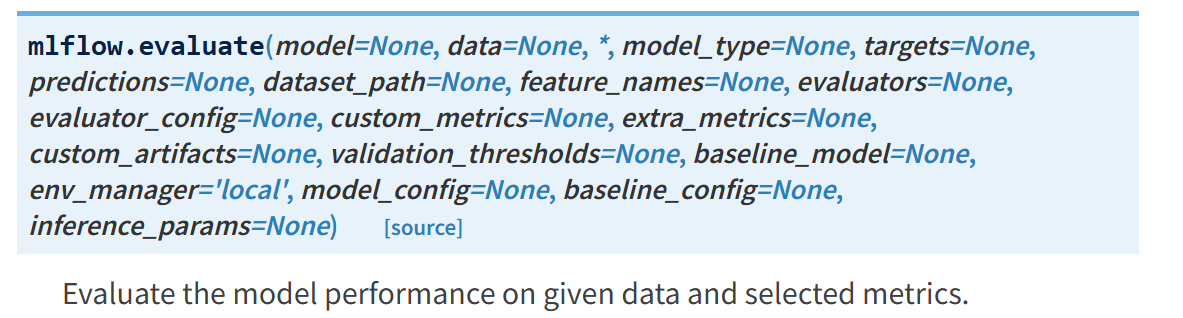

In [ ]:
import mlflow
from mlflow_for_ml_dev.src.utils.folder_operations import get_project_root

# set mlflow tracking uri
mlflow.set_tracking_uri(uri=(get_project_root() / 'mlruns').as_uri())

In [ ]:
experiment_name = "evaluation"
try: 
    _ = mlflow.create_experiment(name=experiment_name)
except mlflow.exceptions.MlflowException:
    experiment = mlflow.get_experiment_by_name(name=experiment_name)
# set experiment
experiment = mlflow.set_experiment(experiment_name)

# Evaluating classifier models

In [ ]:
from sklearn.datasets import make_classification  
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

In [ ]:
# generate some data
X, y = make_classification(n_samples=1000, n_features=4, n_classes=3, random_state=42, scale= 10, n_informative=3, n_redundant=1)
X = pd.DataFrame(X, columns=[f"f_{i}" for i in range(X.shape[1])])
y = pd.Series(y, name="target")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
feature_names = X.columns.tolist()

eval_data = X_test.copy()
eval_data["target"] = y_test

In [ ]:
eval_data.head()

In [ ]:
rfc = RandomForestClassifier()

# train model
rfc.fit(X_train, y_train)

artifact_path = "random_forest_model"
# log the model
with mlflow.start_run(run_name="evaluating_rfc") as run:
    mlflow.sklearn.log_model(rfc, artifact_path)


    # evaluate model
    results = mlflow.evaluate(
        model=f"runs:/{run.info.run_id}/{artifact_path}",
        data = eval_data,
        model_type="classifier",
        targets = "target",
        feature_names=feature_names,
    )

## Evaluating multiple models

In [ ]:
estimators = [2,5,10,20, 30, 50]

rfc_models = {}

for n_estimators in estimators:
    rfc = RandomForestClassifier(n_estimators=n_estimators)
    rfc.fit(X_train, y_train)
    rfc_models[str(n_estimators)] = rfc


# log the models 

with mlflow.start_run(run_name="evaluating-multiple-models") as parent_run:

    for n_estimators, model in rfc_models.items():

        with mlflow.start_run(run_name=f"rfc_{n_estimators}", parent_run_id = parent_run.info.run_id, nested=True) as child_run:
            # log model
            artifact_path = "random_forest_model"
            mlflow.sklearn.log_model(model, artifact_path)
            mlflow.log_param("n_estimators", n_estimators)

            # evaluate model
            results = mlflow.evaluate(
                model=f"runs:/{child_run.info.run_id}/{artifact_path}",
                data = eval_data,
                model_type="classifier",
                targets = "target",
                feature_names=feature_names,
            )

## Evaluating regressors

In [ ]:
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor

In [ ]:
x, y = make_regression(n_samples=1000, n_features=5, noise=0.1, random_state=42)

df = pd.DataFrame(x, columns=[f"feature_{i}" for i in range(5)])
df["target"] = y
df.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns="target"), df["target"], test_size=0.2, random_state=42)
feature_names = X_train.columns.tolist()
eval_data = X_test.copy()
eval_data["target"] = y_test

In [ ]:
# train model
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

artifact_path = "random_forest_regressor_model"
# log the model
with mlflow.start_run(run_name="evaluating_rfr") as run:
    mlflow.sklearn.log_model(rfr, artifact_path)

    # evaluate model
    results = mlflow.evaluate(
        model=f"runs:/{run.info.run_id}/{artifact_path}",
        data = eval_data,
        model_type="regressor",
        targets = "target",
        feature_names=feature_names,
    )